# Surface area duration plots from DEA Waterbodies data <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** [DEA Waterbodies](https://cmi.ga.gov.au/data-products/dea/456/waterboards) time series data (available online)

## Background

A "surface area duration" (SAD) curve depicts the cumulative percentage of time that a waterbody had a larger extent than a given percentage of its maximum extent&mdash;in other words, the total amount of time that a waterbody was at least a certain amount full. These are similar to [flow duration curves](https://doi.org/10.3133/wsp1542A), and describe the long-term behaviour of a waterbody. SAD curves may be useful for identifying different types of waterbodies, which helps us to understand how water is used throughout Australia.


### Digital Earth Australia use case 
The [DEA Waterbodies](https://cmi.ga.gov.au/data-products/dea/456/waterboards) product uses Geoscience Australia’s archive of over 30 years of Landsat satellite imagery to identify where almost 300,000 waterbodies are in the Australian landscape and tells us how the wet surface area within those waterbodies changes over time.
These data can be analysed to obtain insights into the duration and temporal dynamics of inundation for any mapped waterbody in Australia.

## Description

This notebook plots "surface area duration" (SAD) curves, which show for how long a waterbody is filled at a given surface area. 
Such a curve can be generated for any DEA Waterbody. 
We also generate a time-dependent version of this plot called a "short-time surface area duration" (STSAD) curve, which shows how the surface area duration curve varies over time.

This analysis should work for any time series stored in a similar format.

***

## Getting started

Run the first cell, which loads all modules needed for this notebook. Then edit the configuration to match what you want the notebook to output.

### Load modules

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.signal
from pathlib import Path
from matplotlib import pyplot as plt

# Import DEA modules.
import sys
sys.path.insert(1, '../Scripts')
from dea_temporal import calculate_vector_stat

### Configuration

To generate a plot for a waterbody with a given geohash, specify the geohash here:

In [2]:
geohash = "r3f225n9h"  # Weereewa/Lake George

Also specify the window for the STSAD plot. Use 'hann' if you have no opinions on this, or 'boxcar' if you want a window that is easy to think about. You can see a list of possible windows [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html). Hann is fairly standard for short-time transforms like this and will give a smooth STSAD:

![Hann window](https://docs.scipy.org/doc/scipy/reference/_images/scipy-signal-windows-hann-1_00.png)

Boxcar is a sliding window:

![Boxcar window](https://docs.scipy.org/doc/scipy/reference/_images/scipy-signal-windows-boxcar-1_00.png)

In [3]:
window = "hann"

Finally, specify the path to the waterbodies CSVs:

In [4]:
waterbody_csv_path = "https://data.dea.ga.gov.au/projects/WaterBodies/timeseries"

## Load DEA Waterbodies data

The DEA Waterbodies time series are stored as CSV files. 
Each waterbody is labelled by a geohash, e.g. Weereewa is `r3f225n9h`. 
They are stored online (on Amazon S3) in a folder named after the first four characters of the geohash, and the filename is the geohash, e.g. Weereewa is at `https://data.dea.ga.gov.au/projects/WaterBodies/timeseries/r3f2/r3f225n9h.csv`. 
Each CSV has three columns: `Observation Date`, `Wet pixel percentage`, `Wet pixel count (n = ?)` where ? is the total number of observations. 
An example is:

    Observation Date,Wet pixel percentage,Wet pixel count (n = 230894)
    1987-05-29T23:14:29Z,,
    1987-07-16T23:15:29Z,,
    1987-09-02T23:16:50Z,,
    1987-09-18T23:17:13Z,19.9,45926
    
First we will read the CSV containing the surface area vs time observations data directly from the URL path using `pandas`.
We will rename the `Observation Date, Wet pixel percentage, Wet pixel count (n = ?)` columns to more consistent and easier to access names:
```
    date, pc_wet, px_wet
 ```
    
We also ensure that the 'date' column is parsed as a `datetime`, and convert the data percentages to decimals:

In [5]:
# Set path to the CSV file
csv_path = f"{waterbody_csv_path}/{geohash[:4]}/{geohash}.csv"

# Load the data using `pandas`:
time_series = pd.read_csv(csv_path, 
                          header=0,
                          names=["date", "pc_wet", "px_wet"],
                          parse_dates=["date"],
                          index_col="date",
                         )

# Convert percentages into a float between 0 and 1.
time_series.pc_wet /= 100


We can now inspect the first few rows of the data:

In [6]:
time_series.head()

,pc_wet,px_wet
date,,
1987-05-29 23:14:29+00:00,NaN,NaN
1987-07-16 23:15:29+00:00,NaN,NaN
1987-09-02 23:16:50+00:00,NaN,NaN
1987-09-18 23:17:13+00:00,0.199,45926.0
1987-10-04 23:17:34+00:00,NaN,NaN


## Interpolate data to daily values

DEA Waterbodies data is stored with one row per satellite observation. 
To make our data easier to analyse by time, we can use interpolation the data to estimate the percentage coverage of water for every individual day in our time series.

In [7]:
# Round dates in the time series dataset  to the nearest whole day
time_series.index = time_series.index.round(freq="d")

# Create a new `datetime` index with one value for every individual day
# between the first and last DEA Waterbodies observation 
dt_index = pd.date_range(start=time_series.index[0], 
                         end=time_series.index[-1], freq="d")

# Use this new index to modify the original time series so that it 
# has a row for every individual day
time_series = time_series.reindex(dt_index)
assert len(time_series) == len(dt_index)


Then interpolate (linearly, since it's the least-information thing other than constant).

In [8]:
# Replace NaNs with a linear interpolation of the time series.
time_series.pc_wet.interpolate(inplace=True, limit_direction="both")

If we inspect the first rows in the dataset again, we can see that we now have one row for every day (e.g. `1987-05-30`, `1987-05-31`) instead of a row for each satellite observation:

In [9]:
time_series.head()

,pc_wet,px_wet
1987-05-30 00:00:00+00:00,0.199,NaN
1987-05-31 00:00:00+00:00,0.199,NaN
1987-06-01 00:00:00+00:00,0.199,NaN
1987-06-02 00:00:00+00:00,0.199,NaN
1987-06-03 00:00:00+00:00,0.199,NaN


## Calculate SADs

For each rolling time step, calculate the SADs.

In [10]:
def calculate_sad(vec):
    """Calculates the surface area duration curve for a given vector of heights.
    
    Parameters
    ----------
    vec : d-dimensional np.ndarray
        Vector of heights over time.
    
    Returns
    -------
    d-dimensional np.ndarray
        Surface area duration curve vector over the same time scale.
    """
    return np.sort(vec)[::-1]


def calculate_stsad(vec, window_size=365, step=10, progress=None, window="hann"):
    """Calculates the short-time surface area duration curve for a given vector of heights.
    
    Parameters
    ----------
    vec : d-dimensional np.ndarray
        Vector of heights over time.
    window_size : int
        Sliding window size (default 365).
    step : int
        Step size (default 10).
    progress : iterator -> iterator
        Optional progress decorator, e.g. tqdm.notebook.tqdm. Default None.
    window : str
        What kind of window function to use. Default 'hann', but you might
        also want to use 'boxcar'. Any scipy window
        function is allowed (see documentation for scipy.signal.get_window
        for more information).
    
    Returns
    -------
    (d / step)-dimensional np.ndarray
        y values (the time axis)
    t-dimensional np.ndarray
        x values (the statistic axis)
    (d / step) x t-dimensional np.ndarray
        The short-time surface area duration curve array.
    """
    return calculate_vector_stat(
        vec,
        calculate_sad,
        window_size=window_size,
        step=step,
        target_dim=window_size,
        progress=progress,
        window=window,
    )


Calculate the STSAD.

In [11]:
sad_y, sad_x, sads = calculate_stsad(
    time_series.pc_wet, window_size=365 * 2, window=window, step=10
)

Convert the time axis into integers for calculating tick locations.

In [12]:
year_starts = (time_series.index.month == 1) & (time_series.index.day == 1)
year_start_days = (time_series.index - time_series.index[0])[year_starts].days
year_start_years = time_series.index.year[year_starts]

Calculate the overall SAD.

In [13]:
sad = calculate_sad(time_series.pc_wet)

Calculate the SAD for the [Millenium drought](https://doi.org/10.1002/wrcr.20123).

In [14]:
# Select observations between the start and end of the Millenium drought.
millenium_drought_start = pd.to_datetime('2001-01-01', utc=True)
millenium_drought_end = pd.to_datetime('2009-12-12', utc=True)
millenium_drought = (time_series.index > millenium_drought_start) & (time_series.index < millenium_drought_end)

millenium_sad = calculate_sad(time_series.pc_wet[millenium_drought])

## Plot SADs

We can then plot the SAD.

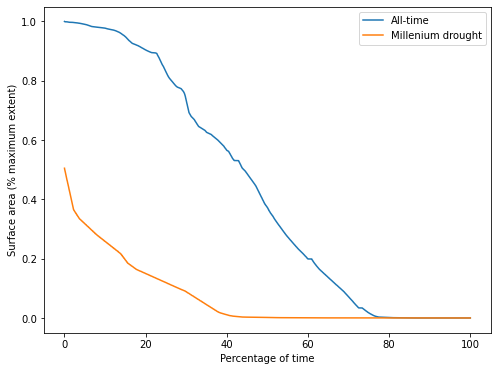

In [15]:
plt.figure(figsize=(8, 6))
xs = np.linspace(0, 100, len(sad))
plt.plot(xs, sad, label='All-time')
xs = np.linspace(0, 100, len(millenium_sad))
plt.plot(xs, millenium_sad, label='Millenium drought')
plt.xlabel("Percentage of time")
plt.ylabel("Surface area (% maximum extent)")
plt.legend();

From this plot of the SAD for Weereewa/Lake George, we can tell that the lake was at least partly-inundated for 25 of the last 33 years. The lake was rarely full. The slope of the curve indicates how the lake varied over time, but is hard to interpret without comparison to another SAD curve.

Comparing the all-time curve to the SAD during the Millenium drought shows that the lake was significantly drier during the drought, never exceeding 50% capacity. The very sharp drop at the beginning of the SAD curve indicates rapid drying when the lake was near its peak, suggesting either that the lake bed is not steep at the point where it is 50% full, or that the only significant influx of water into the lake was during a period of rapid drying.

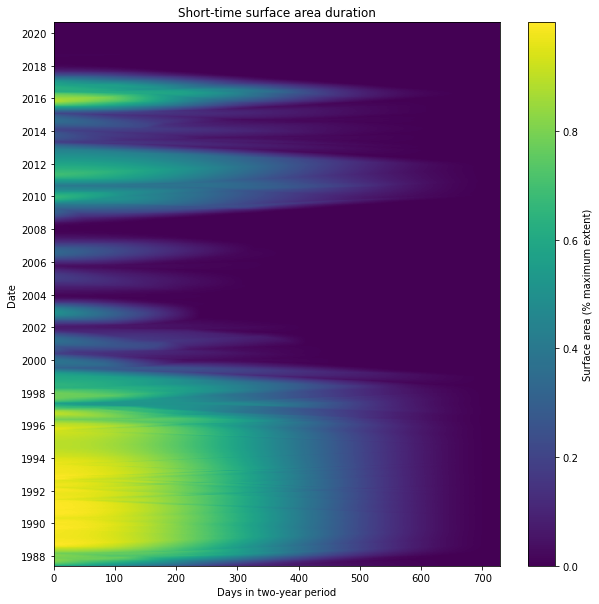

In [16]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(sad_x, sad_y, sads)
plt.xlabel("Days in two-year period")
plt.yticks(year_start_days[::2], year_start_years[::2])
plt.ylabel("Date")
plt.colorbar(label="Surface area (% maximum extent)")
plt.title("Short-time surface area duration");

The STSAD plot helps visualise the change in Weereewa/Lake George over time. Here, the Millenium drought is clearly visible between 2000 and 2009 as a period of very little wet extent. The lake was mostly full during the 1990s, and it filled and dried fairly consistently over time, indicating that it is unregulated. It was stably partly-filled for significant parts of 1988, during the 2010&ndash;12 La Niña, and 2016&ndash;17.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html).